In [1]:
import pystac_client
import planetary_computer
from pystac_client.stac_api_io import StacApiIO
from urllib3 import Retry

import geopandas as gpd
from odc.geo.geom import BoundingBox
import odc.geo.xr

import pandas as pd
import numpy as np
import xarray as xr
from odc.algo import mask_cleanup
from dea_tools.spatial import xr_rasterize

import requests
import xml.etree.ElementTree as ET
from collections import defaultdict

import odc.stac
from odc.stac import configure_rio
from datacube.utils.aws import configure_s3_access
from distributed import LocalCluster, Client

In [ ]:
# Set up Dask Cluster for Parallelization
cluster = LocalCluster(n_workers=12, threads_per_worker=1, processes=False)
client = Client(cluster)
# configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)
configure_rio(cloud_defaults=True, client=client) # For Planetary Computer
print(client.dashboard_link)

http://155.207.39.39:8787/status


c:\Users\fotakidis\anaconda3\envs\drought\Lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [3]:
def check_gri_refinement(items):
    refined_items = []
    refinement_data = []

    # Loop through items and extract `Image_Refining` flag
    for item in items:
        datastrip_metadata_url = None
        for asset_key, asset_data in items[0].assets.items():
            if "datastrip-metadata" in asset_key.lower(): # and asset_data.href.endswith(".xml"):
                # datastrip_metadata_url = planetary_computer.sign(asset_data.href)
                datastrip_metadata_url = asset_data.href
                break

        if datastrip_metadata_url:
            # print(f"Processing: {datastrip_metadata_url}")
            print(f"Processing: {item.id}") #print(f"Processing: {datastrip_metadata_url}")

            # Fetch XML content
            xml_response = requests.get(datastrip_metadata_url)
            if xml_response.status_code == 200:
                root = ET.fromstring(xml_response.content)

                # Extract Image_Refining flag
                refining_element = root.find(".//Geometric_Info/Image_Refining")
                refining_flag = refining_element.get("flag") if refining_element is not None else "Not Found"

                print(f"Image Refining Flag: {refining_flag}")

                # Store item and status in dataframe
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": refining_flag
                })

                # Append to refined_items if the flag is 'REFINED'
                if refining_flag == "REFINED":
                    refined_items.append(item)
            else:
                # print(f"Failed to fetch XML: {xml_response.status_code}")
                refinement_data.append({
                    "item_id": item.id,
                    "refinement_status": "Fetch Failed"
                })
        else:
            # print("datastrip_metadata.xml not found in STAC item")
            refinement_data.append({
                "item_id": item.id,
                "refinement_status": "Metadata Not Found"
            })

    # Create a DataFrame
    df_refinement_status = pd.DataFrame(refinement_data)

    return refined_items, df_refinement_status


In [13]:
aoi.geometry.total_bounds

array([20.34430891, 36.45765223, 24.37428164, 39.24229213])

In [17]:
aoi = gpd.read_file('../anciliary/grid_v2.geojson').to_crs('EPSG:4326')
# Get the bounds of the 9th geometry
minx, miny, maxx, maxy = aoi.iloc[7].geometry.bounds

aoi_bbox = BoundingBox.from_xy(
    (minx, maxx),
    (miny, maxy)
)

In [19]:
aoi.explore()

In [18]:
aoi_bbox.explore()

**SR#1: P01/P02. Limited Sentinel-2 Data Availability due to Cloud Cover**

This issue could arise if there are not enough images to generate monthly mosaics-especially due to winter season.
- Mitigation Measures: Develop bi-monthly image composites using Sentinel-2 imagery.
    - Back-up Measures: If bimonthly composites also fail, we will explore integrating Landsat imagery in the process or generating cloud free subsets within each AOI.


In [20]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-07',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')

Found 5 items


In [21]:
stac_api_io = StacApiIO(max_retries=Retry(total=5, backoff_factor=5))

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
    stac_io=stac_api_io
)

cloud_cover = 70
search = catalog.search(
    collections=["sentinel-2-l2a"], #hls2-s30
    bbox=aoi_bbox,
    datetime='2024-01-01/2024-02-29',
    limit=100,
    query={
        "eo:cloud_cover": {"lt":cloud_cover},
        "s2:nodata_pixel_percentage": {"lt":20},
    },
)

items = search.item_collection()
print(f'Found {len(items)} items')
print(f'Searching for GRI REFINED scenes...')
print(f'###################################')
# Regarding mis-registration (as observed in 2023 vs 2024):
# See: https://forum.step.esa.int/t/geometric-gri-refinement-in-sentinel-2-level-1c-early-images-below-pb-3-0/44024/2
# Finally, the activation of the geometric refining does not mean that the products will be always refined. 
# There are some cases (e.g. too many clouds) where the refining cannot be applied as it would not improve 
# and could degrade the geolocation of the products. This can be checked thanks to the metadata 
# Image_Data_Info/Geometric_Info/Image_Refining in the datastrip matadata file (DATASTRIP/*/MTD_DS.xml). In STAC: datastrip_metadata
# This parameter is equal to REFINED or NOT_REFINED.
#<Geometric_Info metadataLevel="Standard">
#   <RGM>COMPUTED</RGM>
#   <Image_Refining flag="REFINED">
refined_items, df_refinement_status = check_gri_refinement(items)

Found 7 items
Searching for GRI REFINED scenes...
###################################
Processing: S2B_MSIL2A_20240220T093029_R136_T34SDH_20240220T121733
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240215T093101_R136_T34SDH_20240215T141952
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240205T093201_R136_T34SDH_20240205T154053
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240131T093129_R136_T34SDH_20240131T131805
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240126T093251_R136_T34SDH_20240126T142122
Image Refining Flag: REFINED
Processing: S2A_MSIL2A_20240116T093331_R136_T34SDH_20240116T142521
Image Refining Flag: REFINED
Processing: S2B_MSIL2A_20240101T093319_R136_T34SDH_20240101T121856
Image Refining Flag: REFINED


In [22]:
items = refined_items

if len(items) == 0:        
    msg = f"Search returned 0 Items for `cloud cover`={cloud_cover}. Terminating this composite generation."
    print(msg)
    raise ValueError(msg)
else:
    filtered_items = []
    tiles = np.unique([i.properties['s2:mgrs_tile'] for i in items])
    epsgs = np.unique([i.properties['proj:epsg'] for i in items])
    
    for tile in tiles:
        item_mgrs_sorted = sorted([i for i in items if i.properties['s2:mgrs_tile'] == str(tile)], key=lambda item: item.properties['eo:cloud_cover'])
        if len(item_mgrs_sorted) > 10:
            filtered_items.extend(item_mgrs_sorted[:10])
        else:
            filtered_items.extend(item_mgrs_sorted)
    print(f"Filtered cleanest scenes: Kept {len(filtered_items)} out of {len(items)} items. ")
    print(f"Tiles: {tiles}")
    print(f"EPSG: {epsgs[0]}")
    items = filtered_items
    display(items)

Filtered cleanest scenes: Kept 7 out of 7 items. 
Tiles: ['34SDH']
EPSG: 32634


[<Item id=S2A_MSIL2A_20240215T093101_R136_T34SDH_20240215T141952>,
 <Item id=S2B_MSIL2A_20240131T093129_R136_T34SDH_20240131T131805>,
 <Item id=S2A_MSIL2A_20240126T093251_R136_T34SDH_20240126T142122>,
 <Item id=S2A_MSIL2A_20240205T093201_R136_T34SDH_20240205T154053>,
 <Item id=S2B_MSIL2A_20240220T093029_R136_T34SDH_20240220T121733>,
 <Item id=S2A_MSIL2A_20240116T093331_R136_T34SDH_20240116T142521>,
 <Item id=S2B_MSIL2A_20240101T093319_R136_T34SDH_20240101T121856>]

In [23]:
ds_cube = odc.stac.stac_load(
        items,
        bbox=aoi_bbox,
        # bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL'],
        bands=['B02', 'B03', 'B04', 'B8A', 'SCL'],
        chunks=dict(y=1024, x=1024),
        crs=f'epsg:{epsgs[0]}', # Equi7Grid European EPSG (https://github.com/TUW-GEO/Equi7Grid)
        resolution=20,
        groupby='time', # if 'time' loads all items, retaining duplicates
        fail_on_error=True,
        resampling={
            "*": "cubic",
        },
    )
ds_cube

<xarray.Dataset> Size: 1GB
Dimensions:      (y: 2736, x: 2676, time: 7)
Coordinates:
  * y            (y) float64 22kB 4.262e+06 4.262e+06 ... 4.208e+06 4.208e+06
  * x            (x) float64 21kB 4.424e+05 4.425e+05 ... 4.959e+05 4.96e+05
    spatial_ref  int32 4B 32634
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) float32 205MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) float32 205MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) float32 205MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) float32 205MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    SCL          (time, y, x) float32 205MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [24]:
# - 0: no data
# - 1: saturated or defective
# - 2: dark area pixels
# - 3: cloud shadows
# - 4: vegetation
# - 5: bare soils
# - 6: water
# - 7: unclassified
# - 8: cloud medium probability
# - 9: cloud high probability
# - 10: thin cirrus
# - 11: snow or ice
invalid_scl_values = [3, 7, 8, 9, 10, 11]
cloud_binary_mask = ds_cube.SCL.isin(invalid_scl_values)

# bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
bands=['B02', 'B03', 'B04', 'B8A']
ds_cube_cf = ds_cube[bands].where(~cloud_binary_mask, 0).astype('uint16')
ds_cube_cf

<xarray.Dataset> Size: 410MB
Dimensions:      (time: 7, y: 2736, x: 2676)
Coordinates:
  * y            (y) float64 22kB 4.262e+06 4.262e+06 ... 4.208e+06 4.208e+06
  * x            (x) float64 21kB 4.424e+05 4.425e+05 ... 4.959e+05 4.96e+05
    spatial_ref  int32 4B 32634
  * time         (time) datetime64[ns] 56B 2024-01-01T09:33:19.024000 ... 202...
Data variables:
    B02          (time, y, x) uint16 103MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B03          (time, y, x) uint16 103MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B04          (time, y, x) uint16 103MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B8A          (time, y, x) uint16 103MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

In [25]:
ds_cube_cf = ds_cube_cf.where(ds_cube_cf > 0, np.nan)
median_composite = ds_cube_cf[bands].median(dim='time').astype('float32').compute()
median_composite

<xarray.Dataset> Size: 117MB
Dimensions:      (y: 2736, x: 2676)
Coordinates:
  * y            (y) float64 22kB 4.262e+06 4.262e+06 ... 4.208e+06 4.208e+06
  * x            (x) float64 21kB 4.424e+05 4.425e+05 ... 4.959e+05 4.96e+05
    spatial_ref  int32 4B 32634
Data variables:
    B02          (y, x) float32 29MB 1.234e+03 1.238e+03 ... 1.165e+03 1.194e+03
    B03          (y, x) float32 29MB 1.101e+03 1.116e+03 ... 1.087e+03 1.095e+03
    B04          (y, x) float32 29MB 1.031e+03 1.054e+03 ... 1.034e+03 1.024e+03
    B8A          (y, x) float32 29MB 1.03e+03 1.062e+03 ... 1.024e+03 1.03e+03

In [28]:
import rioxarray as rxr

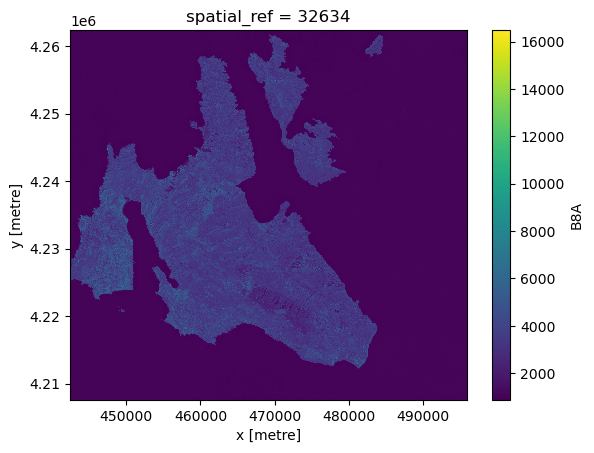

In [27]:
median_composite.B8A.plot()

In [32]:
median_composite = median_composite.astype('int16')
median_composite.B8A.attrs['nodata'] = 0

In [36]:
median_composite.B8A.rio.to_raster('test.tif', driver='COG')

In [38]:
median_composite.B8A.rio.to_raster('//nas-rs.topo.auth.gr/Latomeia/test.tif', driver='COG')

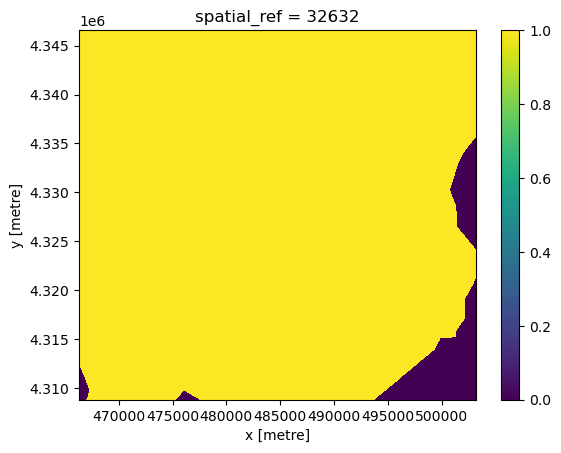

In [27]:
coastline_xr = xr_rasterize(nuts[nuts['NAME_LATN']=='Sardegna'], median_composite)
coastline_xr.plot()

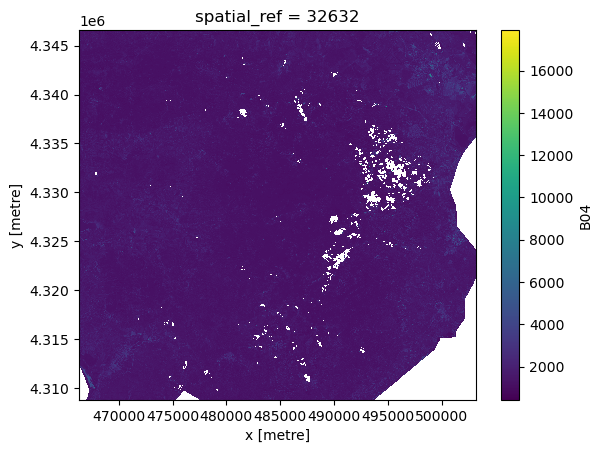

In [28]:
median_composite.where(coastline_xr).B04.plot()